# DSCI-6650 Assignment 1

This assignment explores various RL algorithms used to solve the $k$-armed bandit problem, namely, the greedy, $\varepsilon$-greedy, and gradient bandit algorithms. The goal in this work is to dig into the problem and the algorithms, and the code presented here reflects that goal. Most of what follows is pure Python with liberal usage of the NumPy library, with no vectorization or parallelism included. This comes with the drawback that the simulations are slightly time consuming, but also with the benefit that the logic of the code closely follows the logic of the algorithms without much of the obfuscation that can come with vectorization and parallelism.

The layout of this work is broken up into two main sections, as follows:
1. Implementations of the various concepts are introduced using the object-oriented paradigm. The reader is asked to forgive some of the potentially questionable design choices, by which it is meant that some of the objects and design patterns are overly generic for the use case, resulting in, arguably, more complexity than necessary.
2. Experiments consisting of multiple simulation runs are conducted and the results visualized and discussed.


## Preliminaries

As a first step, we set up common dependencies that will be used throughout what follows. To begin, we import the necessary libraries:

In [1]:
from dataclasses import dataclass
from enum import StrEnum, auto
from tqdm.notebook import tqdm
from typing import Callable, Protocol

import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from scipy.stats import norm


Now, we define a class to implement the concept of an action (i.e., an _arm_ of the bandit). When we execute an action, we receive a reward sampled from a normal distribution with a specified mean and standard deviation. Per our problem specification, the standard deviation of all actions is $1$. We leave the mean as a parameter to be passed in. Calling `Action.execute` is our implementation of pulling an arm of the bandit.


In [2]:
ACTION_REWARD_STDEV: float = 1.0


class Action:
    """
    Represents an arm in a k-armed bandit environment, modeled as a normal distribution
    with a given (possibly variable) mean and standard deviation.

    Parameters
    ----------
    mean : np.float64
        The mean of the reward distribution associated with this action.
    rng : np.random.Generator
        A NumPy random number generator used to sample rewards.

    Attributes
    ----------
    mean : np.float64
        The mean of the reward distribution.
    rng : np.random.Generator
        The random number generator used for sampling.
    """

    def __init__(self, mean: np.float64, rng: np.random.Generator):
        self.mean: np.float64 = mean
        self.rng: np.random.Generator = rng

    def execute(self) -> np.float64:
        """
        Samples a reward from the action's normal distribution.

        Returns
        -------
        np.float64
            A sampled reward from N(mean, ACTION_REWARD_STDEV^2).
        """
        return self.rng.normal(loc=self.mean, scale=ACTION_REWARD_STDEV)


To aide in managing the non-stationary portion of the assignment, we define a sort of "action manager" class which maintains references to each of the actions and serves as a way to track and update the actions' reward distribution means.

This is where we implement the logic for producing non-stationary reward distributions, which come in three flavours:
1. Gradual drift - Each mean is updated according to $\mu_{i, t + 1} = \mu_{i, t} + \varepsilon_{i, t}$, where $\varepsilon_{i, t}$ is sampled from a normal distribution.
2. Mean-reverting change - Each mean is updated according to $\mu_{i, t + 1} = \kappa \mu_{i, t} + \varepsilon_{i, t}$, where $\kappa = 0.5$ and, again, $\varepsilon_{i, t}$ is sampled from a normal distribution.
3. Random permutation - The action means are randomly permuted at a set time step.

To keep things consistent, the stationary reward distribution scenario is also implemented as a subclass of `Actions`. It should also be noted that both the gradual drift and mean-reverting change are implemented in the same `DriftingActions` class, with the former being a special case of the latter with $\kappa = 1$.

Arguably, these classes are overkill for the stationary and gradually drifting non-stationary reward distributions, but will be particularly useful when we implement a permutation of the means. This design choice allows a uniform interface for all of the stationary and non-stationary scenarios, and allows for some nice simplifications of the actual simulation code, as will be seen later on. It also allows us to encapsulate the logic of each type of non-stationarity behind a single method, namely, the `update` method.


In [ ]:
class Actions:
    """
    A container class for a collection of `Action` instances.

    Provides access, updating, and utility methods.

    Parameters
    ----------
    actions : list of Action
        A list of Action objects. Must contain at least one action.

    Raises
    ------
    ValueError
        If no actions are provided.
    """

    def __init__(self, actions: list[Action]):
        if len(actions) < 1:
            raise ValueError(f"Must provide at least one possible action")
        self.actions: list[Action] = actions

    def __getitem__(self, index: np.int64) -> Action:
        """
        Retrieve the action at the specified index.

        Parameters
        ----------
        index : int
            Index of the action to retrieve.

        Returns
        -------
        Action
            The action at the given index.
        """
        return self.actions[index]

    def update(self, time_step: np.int64) -> None:
        """
        Update the internal state of actions.

        To be implemented by subclasses.

        Parameters
        ----------
        time_step : int
            The current simulation time step.

        Raises
        ------
        NotImplementedError
            If not implemented in a subclass.
        """
        raise NotImplementedError()

    def get_optimal(self) -> np.int64:
        """
        Return the index of the action with the highest mean reward.

        Returns
        -------
        int
            Index of the optimal action.
        """
        return np.argmax([action.mean for action in self.actions])


class StationaryActions(Actions):
    """
    A subclass of Actions where action reward distributions remain constant over time.
    """

    def update(self, time_step: np.int64) -> None:
        """
        No-op update. Stationary actions do not change over time.

        Parameters
        ----------
        time_step : int
            The current simulation time step. (Unused)
        """
        pass


class DriftingActions(Actions):
    """
    Actions whose mean rewards drift over time following a potentially mean-reverting
    process. If the `mean_persistence` is one, the process is just a gradual drift and
    is not mean-reverting.

    Parameters
    ----------
    actions : list of Action
        List of Action objects to manage.
    mean_persistence : float
        The persistence factor for the means.
    drift_mean : float
        Mean of the Gaussian noise added to each mean.
    drift_stdev : float
        Standard deviation of the noise added to each mean.
    drift_rngs : list of np.random.Generator
        Random number generators for each action.
    """

    def __init__(
        self,
        actions: list[Action],
        mean_persistence: np.float64,
        drift_mean: np.float64,
        drift_stdev: np.float64,
        drift_rngs: list[np.random.Generator]
    ) -> None:
        super().__init__(actions)
        self.mean_persistence = mean_persistence
        self.drift_mean: np.float64 = drift_mean
        self.drift_stdev: np.float64 = drift_stdev
        self.drift_rngs: list[np.random.Generator] = drift_rngs

    def update(self, time_step: np.int64) -> None:
        """
        Apply a potentially mean-reverting Gaussian update to each action's reward mean.

        Parameters
        ----------
        time_step : int
            The current simulation time step. (Unused)
        """
        for action, rng in zip(self.actions, self.drift_rngs):
            action.mean = self.mean_persistence * action.mean \
                + rng.normal(loc=self.drift_mean, scale=self.drift_stdev)


class PermutingMeanActions(Actions):
    """
    Actions whose reward means are permuted at a specific simulation time step.

    Parameters
    ----------
    actions : list of Action
        List of Action objects to manage.
    permutation_time_step : int
        The time step at which to shuffle the reward means among actions.
    permutation_rng : np.random.Generator
        Random number generator used to perform the permutation.
    """

    def __init__(
        self,
        actions: list[Action],
        permutation_time_step: np.int64,
        permutation_rng: np.random.Generator
    ) -> None:
        super().__init__(actions)
        self.permutation_time_step: np.int64 = permutation_time_step
        self.permutation_rng: np.random.Generator = permutation_rng

    def update(self, time_step: np.int64) -> None:
        """
        Shuffle the reward means among all actions at the defined permutation time step.

        Parameters
        ----------
        time_step : int
            The current simulation time step.
        """
        if time_step == self.permutation_time_step:
            means: list[np.float64] = [action.mean for action in self.actions]
            self.permutation_rng.shuffle(means)
            for mean, action in zip(means, self.actions):
                action.mean = mean


To simplify the simulation setup code and separate responsibilities, we use the factory design pattern to create instances of the `Actions` subclasses. These factory classes are defined here.

Importantly, the drifting and mean-permuting `ActionsFactory` subclasses require a seed value to be passed in upon instantiation. This is used to ensure that each of the `Actions` objects produced will follow the same sequence of non-stationary updates to the actions' reward distribution means (i.e., the same sequence of $\varepsilon_{i, t}$ for the drifting versions, and the same permutation for the mean permuting version).


In [4]:
class ActionsFactory:
    """
    Abstract base class for factories that produce `Actions` instances from a set of initial means.

    Parameters
    ----------
    action_means : np.ndarray of float
        Array of initial mean rewards for each action.
    """

    def __init__(self, action_means: npt.NDArray[np.float64]) -> None:
        self.action_means: npt.NDArray[np.float64] = action_means

    def get_actions(self, action_rng: np.random.Generator) -> Actions:
        """
        Construct an Actions instance using the provided RNG.

        Parameters
        ----------
        action_rng : np.random.Generator
            Random number generator used to sample rewards from actions.

        Returns
        -------
        Actions
            A collection of actions constructed by the factory.

        Raises
        ------
        NotImplementedError
            This method must be implemented in a subclass.
        """
        raise NotImplementedError()


class StationaryActionsFactory(ActionsFactory):
    """
    Factory that produces `StationaryActions` objects with fixed mean rewards.

    Parameters
    ----------
    action_means : np.ndarray of float
        Array of mean rewards for each stationary action.
    """

    def __init__(self, action_means: npt.NDArray[np.float64]) -> None:
        super().__init__(action_means)

    def get_actions(self, action_rng: np.random.Generator) -> Actions:
        """
        Create a `StationaryActions` instance with fixed mean actions.

        Parameters
        ----------
        action_rng : np.random.Generator
            Random number generator used to sample action rewards.

        Returns
        -------
        StationaryActions
            A collection of stationary actions.
        """
        return StationaryActions([Action(mean, action_rng) for mean in self.action_means])


class DriftingActionsFactory(ActionsFactory):
    """
    Factory that produces `DriftingActions` objects with mean-reverting Gaussian drift.

    Parameters
    ----------
    action_means : np.ndarray of float
        Array of initial mean rewards for each action.
    mean_persistence : float
        Persistence factor (kappa) controlling mean reversion strength.
    drift_mean : float
        Mean of the Gaussian drift term added to each action.
    drift_stdev : float
        Standard deviation of the drift noise.
    drift_seed : int
        Seed used to generate per-action random number generators for reproducibility.
    """

    def __init__(
        self,
        action_means: npt.NDArray[np.float64],
        mean_persistence: np.float64,
        drift_mean: np.float64,
        drift_stdev: np.float64,
        drift_seed: np.int64
    ) -> None:
        super().__init__(action_means)
        self.mean_persistence: np.float64 = mean_persistence
        self.drift_mean: np.float64 = drift_mean
        self.drift_stdev: np.float64 = drift_stdev
        self.drift_seed: np.int64 = drift_seed

    def get_actions(self, action_rng: np.random.Generator) -> Actions:
        """
        Create a `DriftingActions` instance with mean-reverting Gaussian drift dynamics.

        A unique random number generator is created for each action using the provided drift seed,
        ensuring that drift behavior is reproducible across simulations.

        Parameters
        ----------
        action_rng : np.random.Generator
            Random number generator used to sample initial rewards.

        Returns
        -------
        DriftingActions
            A collection of drifting actions with independent noise processes.
        """
        seeds: npt.NDArray[np.int64] = np.random.default_rng(self.drift_seed).integers(
            10_000, size=self.action_means.size
        )
        return DriftingActions(
            [Action(mean, action_rng) for mean in self.action_means],
            self.mean_persistence,
            self.drift_mean,
            self.drift_stdev,
            [np.random.default_rng(seed) for seed in seeds]
        )


class PermutingMeanActionsFactory(ActionsFactory):
    """
    Factory that produces `PermutingMeanActions` objects whose means are randomly permuted
    at a specified simulation time step.

    Parameters
    ----------
    action_means : np.ndarray of float
        Initial mean rewards for each action.
    permutation_time_step : int
        Time step at which to permute the action means.
    permutation_seed : int
        Seed used to initialize the permutation RNG for reproducibility.
    """

    def __init__(
        self,
        action_means: npt.NDArray[np.float64],
        permutation_time_step: np.int64,
        permutation_seed: np.int64
    ) -> None:
        super().__init__(action_means)
        self.permutation_time_step: np.int64 = permutation_time_step
        self.permutation_seed: np.int64 = permutation_seed

    def get_actions(self, action_rng: np.random.Generator) -> Actions:
        """
        Create a `PermutingMeanActions` instance that permutes action means at a set time step.

        Parameters
        ----------
        action_rng : np.random.Generator
            Random number generator used to sample initial rewards.

        Returns
        -------
        PermutingMeanActions
            A collection of actions with permuted means at the specified time step.
        """
        return PermutingMeanActions(
            [Action(mean, action_rng) for mean in self.action_means],
            self.permutation_time_step,
            np.random.default_rng(self.permutation_seed)
        )


Next, we implement the Greedy, $\varepsilon$-Greedy, and Gradient policies as concretions of a `Policy`. This is not implemented as a class hierarchy because nothing, other than the contract of implementing the required `select_action` and `update` methods, needs to be inherited from `Policy`. Instead, the policies just follow the protocol defined by `Policy`.

We implement three types of policy here:

1. Greedy - The action with the max reward sample average is chosen. Technically, this is not explicitly implemented; instead, it is implemented as a special case of an $\varepsilon$-greedy policy with $\varepsilon = 0$.
2. $\varepsilon$-Greedy - The action with the max reward sample average is chosen with probability $1 - \varepsilon$, where $\varepsilon \in [0, 1]$, and a random action is chosen with probility $\varepsilon$. If $\varepsilon = 0$, as noted above, the action with maximum reward sample average is always chosen, and this reverts to the pure greedy policy. If, on the other hand, $\varepsilon = 1$, this is just a random policy, where the actions are chosen from uniformly.
3. Gradient - We associate a preference $H(a)$ with each action $a$, and randomly choose amongst the actions with probability distribution defined by a softmax over the action preferences, denoted $\pi_t(a)$. At each step $t$, after choosing an action $A_t$, the preferences are updated according to
$$
H_{t + 1}(a) = \begin{cases}
    H_t(a) + \alpha (R_t - \bar{R}_t) (1 - \pi_t(a)) \quad & \text{if } a = A_t \\
    H_t(a) - \alpha (R_t - \bar{R}_t) \pi_t(a)       \quad & \text{otherwise}
\end{cases},
$$
where $\alpha$ is a learning rate or step size parameter, and $\bar{R}_t$ is the average of the rewards up to, but not including, time $t$.

Per the name, the `Policy.select_action` method is used to select an action according to the specific policy. In addition, a `Policy.update` method is provided which is used to modify the action-values for the greedy and $\varepsilon$-greedy policies, and to modify the preferences for the gradient policy.

To allow for the case where we do a hard reset on the policies at a given time step, we introduce a `reset_step` argument that is used to set a specific time step where we do the hard reset, pass the current time step to the `update` method, and, if appropriate, reset the policy.


In [ ]:
class Policy(Protocol):
    """
    Protocol interface for reinforcement learning policies.

    Defines the methods that all policy implementations must provide.
    """

    def select_action(self, rng: np.random.Generator) -> np.int64:
        """
        Select an action based on the policy.

        Parameters
        ----------
        rng : np.random.Generator
            Random number generator used for action selection.

        Returns
        -------
        int
            Index of the selected action.
        """
        raise NotImplementedError()

    def update(self, selected_action: int, reward: float, time_step: int) -> None:
        """
        Update the policy based on the received reward.

        Parameters
        ----------
        selected_action : int
            The index of the action that was selected.
        reward : float
            The reward received for the selected action.
        time_step : int
            The current time step in the simulation.
        """
        raise NotImplementedError()


class EpsilonGreedyPolicy:
    """
    Epsilon-greedy policy for balancing exploration and exploitation.

    Parameters
    ----------
    epsilon : float
        Probability of selecting a random action (exploration).
    reward_sample_averages : np.ndarray of float
        Initial estimates of the average reward for each action.
    reset_step : int or None
        Optional time step at which to reset policy state to its initial values.
    """

    def __init__(self, epsilon: float, reward_sample_averages: npt.NDArray[np.float64], reset_step: int | None) -> None:
        if epsilon < 0.:
            raise ValueError(f"Epsilon must be non-negative, not {epsilon}")
        if reward_sample_averages.ndim != 1:
            raise ValueError(f"Reward sample averages must be a 1-dimensional array, not {reward_sample_averages.shape}")
        self.epsilon: float = epsilon
        self.initial_reward_sample_averages: npt.NDArray[np.float64] = reward_sample_averages.copy()
        self.reward_sample_averages: npt.NDArray[np.float64] = reward_sample_averages.copy()
        self.action_selection_counts: npt.NDArray[np.int64] = np.zeros_like(reward_sample_averages, dtype=np.int64)
        self.reset_step: int | None = reset_step

    def select_action(self, rng: np.random.Generator) -> np.int64:
        """
        Select an action using the epsilon-greedy strategy.

        With probability `1 - epsilon`, chooses the action with the highest
        sample average reward. Otherwise, selects an action uniformly at random.

        In case there are multiple actions with the same highest reward sample
        average, an action among those will be selected uniformly at random.

        Parameters
        ----------
        rng : np.random.Generator
            Random number generator used for sampling.

        Returns
        -------
        int
            Index of the selected action.
        """
        if np.isclose(self.epsilon, 0.) or rng.random() >= self.epsilon:
            # Exploitation: Choose the action with the max action-value
            max_reward_sample_average: np.float64 = np.max(self.reward_sample_averages)
            best_actions: npt.NDArray[np.int64] = np.flatnonzero(
                np.isclose(self.reward_sample_averages, max_reward_sample_average)
            )
            selected_action: np.int64 = rng.choice(best_actions)
        else:
            # Exploration: Randomly select an action
            selected_action: np.int64 = rng.integers(self.reward_sample_averages.size)

        self.action_selection_counts[selected_action] += 1

        return selected_action

    def update(self, selected_action: int, reward: float, time_step: int) -> None:
        """
        Update the reward sample average for the selected action.

        Uses an incremental update rule based on the number of times the action has been selected.

        Parameters
        ----------
        selected_action : int
            The index of the selected action.
        reward : float
            The observed reward.
        time_step : int
            The current time step in the simulation.
        """
        if self.reset_step is not None and time_step == self.reset_step:
            self.reward_sample_averages = self.initial_reward_sample_averages
            self.action_selection_counts = np.zeros_like(self.reward_sample_averages, dtype=np.int64)
            return

        reward = np.float64(reward)
        selection_count = self.action_selection_counts[selected_action]
        current_average_reward = self.reward_sample_averages[selected_action]
        error_term = reward - current_average_reward
        step_size = 1.0 / selection_count

        self.reward_sample_averages[selected_action] = current_average_reward + step_size * error_term


class GradientPolicy:
    """
    Gradient-based policy for preference learning in multi-armed bandit problems.

    Parameters
    ----------
    step_size : float
        Step size (learning rate) for updating preferences.
    preferences : np.ndarray of float
        Initial preference values for each action.
    reset_step : int or None
        Optional time step at which to reset preferences and average reward.
    """

    def __init__(self, step_size: float, preferences: npt.NDArray[np.float64], reset_step: int | None) -> None:
        self.step_size: np.float64 = step_size
        self.initial_preferences: npt.NDArray[np.float64] = preferences.copy()
        self.preferences: npt.NDArray[np.float64] = preferences.copy()
        self.average_reward: float = 0.0
        self.reset_step: int | None = reset_step

    def select_action(self, rng: np.random.Generator) -> np.int64:
        """
        Select an action based on softmax over preferences.

        Since the selection is based on a probability distribution, ties in
        preference are broken at random.

        Parameters
        ----------
        rng : np.random.Generator
            Random number generator used for sampling.

        Returns
        -------
        int
            Index of the selected action.
        """
        probabilities = self._get_softmax_of_preferences()
        return rng.choice(len(self.preferences), p=probabilities)

    def update(self, selected_action: int, reward: float, time_step: int) -> None:
        """
        Update the preference values using the gradient bandit algorithm.

        Parameters
        ----------
        selected_action : int
            The index of the action selected.
        reward : float
            The reward received for the action.
        time_step : int
            The current time step in the simulation.
        """
        if self.reset_step is not None and time_step == self.reset_step:
            self.preferences = self.initial_preferences
            self.average_reward = 0.0
            return

        probabilities = self._get_softmax_of_preferences()
        error_term = reward - self.average_reward

        for action in range(len(self.preferences)):
            if action == selected_action:
                preference_update = self.step_size * error_term * (1 - probabilities[action])
            else:
                preference_update = -self.step_size * error_term * probabilities[action]
            self.preferences[action] += preference_update

        average_reward_update_step_size = 1.0 / time_step
        self.average_reward += average_reward_update_step_size * error_term

    def _get_softmax_of_preferences(self) -> npt.NDArray[np.float64]:
        """
        Compute the softmax probabilities from the current preferences.

        Returns
        -------
        np.ndarray of float
            Softmax probabilities over the preferences.
        """
        exp_preferences = np.exp(self.preferences)
        return exp_preferences / np.sum(exp_preferences)


Similar to the approach used for `Actions` instances, we use the factory pattern to create instances of the various `Policy` implementations.

In [6]:
class PolicyFactory(Protocol):
    """
    Protocol for a factory that constructs policy objects.

    This interface defines the method all concrete policy factories must implement.
    """

    def get_policy(self) -> Policy:
        """
        Create and return a new policy instance.

        Returns
        -------
        Policy
            A new instance of a policy implementing the Policy protocol.
        """
        raise NotImplementedError()


class GreedyPolicyFactory:
    """
    Factory for creating epsilon-greedy policies with epsilon = 0 (pure greedy).

    Parameters
    ----------
    reward_sample_averages : np.ndarray of float
        Initial estimates of the average reward for each action.
    reset_step : int or None, optional
        If set, resets the policy to its initial state at the specified time step.
    """

    def __init__(self, reward_sample_averages: npt.NDArray[np.float64], reset_step: int | None = None) -> None:
        self.reward_sample_averages: npt.NDArray[np.float64] = reward_sample_averages.copy()
        self.reset_step: int | None = reset_step

    def get_policy(self) -> Policy:
        """
        Create a greedy policy (epsilon = 0.0).

        Returns
        -------
        Policy
            A greedy epsilon-greedy policy instance.
        """
        return EpsilonGreedyPolicy(0., self.reward_sample_averages, self.reset_step)


class EpsilonGreedyPolicyFactory:
    """
    Factory for creating epsilon-greedy policy instances.

    Parameters
    ----------
    epsilon : float
        Probability of exploration (random action selection).
    reward_sample_averages : np.ndarray of float
        Initial estimates of the average reward for each action.
    reset_step : int or None, optional
        If set, resets the policy to its initial state at the specified time step.
    """

    def __init__(self, epsilon: float, reward_sample_averages: npt.NDArray[np.float64], reset_step: int | None = None) -> None:
        self.epsilon: float = epsilon
        self.reward_sample_averages: npt.NDArray[np.float64] = reward_sample_averages.copy()
        self.reset_step: int | None = reset_step

    def get_policy(self) -> Policy:
        """
        Create an epsilon-greedy policy.

        Returns
        -------
        Policy
            An epsilon-greedy policy instance with configured epsilon.
        """
        return EpsilonGreedyPolicy(self.epsilon, self.reward_sample_averages, self.reset_step)


class GradientPolicyFactory:
    """
    Factory for creating gradient-based policy instances.

    Parameters
    ----------
    step_size : float
        Learning rate for updating preferences.
    preferences : np.ndarray of float
        Initial preference values for each action.
    reset_step : int or None, optional
        If set, resets the policy to its initial state at the specified time step.
    """

    def __init__(self, step_size: float, preferences: npt.NDArray[np.float64], reset_step: int | None = None) -> None:
        self.step_size: float = step_size
        self.preferences: npt.NDArray[np.float64] = preferences
        self.reset_step: int | None = reset_step

    def get_policy(self) -> Policy:
        """
        Create a gradient-based policy.

        Returns
        -------
        Policy
            A gradient bandit policy instance using softmax over preferences.
        """
        return GradientPolicy(self.step_size, self.preferences, self.reset_step)


Next, we implement the simulation logic. To keep the interface clean, we define a `SimulationInput` data class that contains the necessary information to define a simulation, and a `SimulationOutput` data class that contains the data required to perform the desired analysis of the performance of the various algorithms (i.e., policies) in the various scenarios posed in the assignment specification.

The simulation logic itself is fairly straightforward, with each simulation run happening in a loop over the time steps. The logic for updating the actions and the policies are encapsulated in the `Actions` and `Policy` concretions defined above, which helps to keep things simple here.

We also implement a utility function for generating batches of simulation inputs which we will use to set up the simulations for each of the scenarios we will study.

Finally, we implement a utility function for running batches of simulations.


In [7]:
@dataclass
class SimulationInput:
    """
    Input configuration for a single simulation run.

    Attributes
    ----------
    num_steps : int
        Number of time steps in the simulation.
    actions : Actions
        The environment's available actions.
    policy : Policy
        The action selection strategy used in the simulation.
    random_number_generator : np.random.Generator
        Random number generator used for reproducibility.
    """

    num_steps: int
    actions: Actions
    policy: Policy
    random_number_generator: np.random.Generator

    def __post_init__(self):
        if self.num_steps <= 0:
            raise ValueError(f"Number of simulation steps must be positive, not {self.num_steps}")


@dataclass
class SimulationOutput:
    """
    Results of a single simulation run.

    Attributes
    ----------
    selected_actions : np.ndarray of int
        Array recording which action was selected at each time step.
    rewards : np.ndarray of float
        Array of received rewards for each time step.
    optimal_actions : np.ndarray of int
        Array of optimal actions (i.e., actions with the highest mean reward) at each time step.
    """

    selected_actions: npt.NDArray[np.int64]
    rewards: npt.NDArray[np.float64]
    optimal_actions: npt.NDArray[np.int64]


class Simulation:
    """
    Class to simulate a reinforcement learning agent interacting with a bandit environment.

    Parameters
    ----------
    simulation_input : SimulationInput
        Configuration and dependencies for the simulation run.
    """

    def __init__(self, simulation_input: SimulationInput):
        self.num_steps: int = simulation_input.num_steps
        self.actions: Actions = simulation_input.actions
        self.policy: Policy = simulation_input.policy
        self.rng: np.random.Generator = simulation_input.random_number_generator
    
    def run(self) -> SimulationOutput:
        """
        Run the simulation loop for the specified number of time steps.

        At each step:
        - An action is selected by the policy.
        - The selected action is executed and a reward is received.
        - The policy is updated based on the reward.
        - The environment (actions) may update over time.

        Returns
        -------
        SimulationOutput
            Output data from the simulation including selected actions, rewards, and optimal actions.
        """
        selected_actions: npt.NDArray[np.int64] = np.zeros(self.num_steps, dtype=np.int64)
        rewards: npt.NDArray[np.float64] = np.zeros(self.num_steps, dtype=np.float64)
        optimal_actions: npt.NDArray[np.int64] = np.zeros(self.num_steps, dtype=np.int64)

        for time_step in range(1, self.num_steps + 1):
            selected_action: np.int64 = self.policy.select_action(self.rng)
            reward: np.float64 = self.actions[selected_action].execute()

            selected_actions[time_step - 1] = selected_action
            rewards[time_step - 1] = reward
            optimal_actions[time_step - 1] = self.actions.get_optimal()

            self.policy.update(selected_action, reward, time_step)
            self.actions.update(time_step)

        return SimulationOutput(selected_actions, rewards, optimal_actions)


def get_simulation_inputs(
    num_simulations: int,
    num_steps_per_sim: int,
    actions_factory: ActionsFactory,
    policy_factory: PolicyFactory,
    random_number_generator: np.random.Generator 
) -> list[SimulationInput]:
    """
    Generate input configurations for multiple simulations.

    Each simulation is initialized with a unique RNG derived from the master RNG to ensure reproducibility
    and controlled randomness.

    Parameters
    ----------
    num_simulations : int
        Number of simulations to generate.
    num_steps_per_sim : int
        Number of time steps for each simulation.
    actions_factory : ActionsFactory
        Factory for creating environments (action sets).
    policy_factory : PolicyFactory
        Factory for creating policy instances.
    random_number_generator : np.random.Generator
        RNG used to generate seeds for each individual simulation.

    Returns
    -------
    list of SimulationInput
        List of simulation input configurations.
    """
    simulation_seeds: npt.NDArray[np.int64] = random_number_generator.integers(
        low=0,
        high=1000,
        size=num_simulations,
        dtype=np.int64
    )
    simulation_rngs: list[np.random.Generator] = [
        np.random.default_rng(seed) for seed in simulation_seeds
    ]
    
    simulation_inputs: list[SimulationInput] = []
    for rng in simulation_rngs:
        simulation_inputs.append(
            SimulationInput(
                num_steps=num_steps_per_sim,
                actions=actions_factory.get_actions(rng),
                policy=policy_factory.get_policy(),
                random_number_generator=rng
            )
        )

    return simulation_inputs


def run_simulations(simulation_inputs: list[SimulationInput]) -> list[SimulationOutput]:
    """
    Run a batch of simulations sequentially.

    Parameters
    ----------
    simulation_inputs : list of SimulationInput
        A list of simulation configurations to execute.

    Returns
    -------
    list of SimulationOutput
        A list of results from each simulation.
    """
    simulation_data: list[SimulationOutput] = []
    for simulation_input in tqdm(simulation_inputs):
        simulation_data.append(Simulation(simulation_input).run())

    return simulation_data


The two main metrics we will use to measure the performance of each of the algorithms will be the average per-step reward and the proportion of time the optimal action was taken. To ease the extraction and visualization of these data from the simulation outputs, we define utility functions that will be used extensively during the analysis of the simulation data.

In [8]:
def get_average_reward_curve(simulation_data: list[SimulationOutput]) -> npt.NDArray[np.float64]:
    """
    Compute the average reward per time step across multiple simulation runs.

    Parameters
    ----------
    simulation_data : list of SimulationOutput
        A list of simulation results, each containing a reward time series.

    Returns
    -------
    np.ndarray of shape (num_steps,)
        The mean reward at each time step across all simulation runs.
    """
    # Extract the rewards array from each simulation output
    # Each rewards array is 1-dimensional with length = number of steps
    rewards: list[npt.NDArray[np.float64]] = [d.rewards for d in simulation_data]
    
    # Stack all reward arrays vertically to form a 2D array of shape (num_simulations, num_steps)
    reward_matrix: npt.NDArray[np.float64] = np.vstack(rewards)
    
    # Compute the mean reward across all simulations at each time step (axis=0)
    # This results in a 1D array representing the average reward per step
    average_reward_curve: npt.NDArray[np.float64] = np.mean(reward_matrix, axis=0)
    
    return average_reward_curve


def plot_average_reward_curves(average_reward_curves: dict) -> None:
    """
    Plot average reward curves for one or more sets of simulation results.

    Parameters
    ----------
    average_reward_curves : dict
        A dictionary where keys are tuples of labels (e.g., strategy names),
        and values are 1D NumPy arrays representing average reward per time step.

    Returns
    -------
    None
        Displays a matplotlib plot.
    """
    plt.figure(figsize=(10, 6))
    for key, average_rewards_curve in average_reward_curves.items():
        plt.plot(average_rewards_curve, label=", ".join(key))
    plt.title("Average Reward per Simulation Step")
    plt.xlabel("Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


In [9]:
def get_optimal_action_curve(simulation_data: list[SimulationOutput]) -> npt.NDArray[np.float64]:
    """
    Compute the fraction of simulations in which the optimal action was selected at each time step.

    Parameters
    ----------
    simulation_data : list[SimulationOutput]
        A list of simulation results, each containing the actions selected and the optimal actions
        at each time step during the simulation.

    Returns
    -------
    npt.NDArray[np.float64]
        The average (across simulations) of the indicator that the optimal action was selected
        at each time step, represented as a fraction between 0 and 1.
    """
    # Extract selected actions from each simulation output
    selected_actions: list[npt.NDArray[np.int64]] = [d.selected_actions for d in simulation_data]
    
    # Extract optimal actions from each simulation output
    optimal_actions: list[npt.NDArray[np.int64]] = [d.optimal_actions for d in simulation_data]

    # Perform elementwise comparison of selected vs optimal actions for each simulation
    # Each element is a boolean array indicating whether the selected action matches the optimal action
    comparisons: list[npt.NDArray[np.bool_]] = [sel == opt for sel, opt in zip(selected_actions, optimal_actions)]

    # Stack all boolean arrays vertically into a 2D array of shape (num_simulations, num_steps)
    comparison_matrix: npt.NDArray[np.bool_] = np.vstack(comparisons)

    # Compute the mean along the simulations axis (rows), yielding fraction of optimal actions chosen at each step
    optimal_action_fraction: npt.NDArray[np.float64] = comparison_matrix.mean(axis=0)

    return optimal_action_fraction


def plot_optimal_action_curves(optimal_action_curves: dict) -> None:
    """
    Plot the percentage of optimal actions selected at each time step for different strategies.

    Parameters
    ----------
    optimal_action_curves : dict
        A dictionary mapping strategy identifiers (as tuples of labels) to NumPy arrays
        representing the optimal action selection percentage at each time step.

    Returns
    -------
    None
        Displays a line plot with one curve per strategy.
    """
    plt.figure(figsize=(10, 6))
    for key, optimal_action_curve in optimal_action_curves.items():
        plt.plot(optimal_action_curve, label=", ".join(key))
    plt.title("Optimal Action Percentage per Simulation Step")
    plt.xlabel("Step")
    plt.ylabel("% Optimal Action")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))  # Format y-axis as percentage
    plt.legend()
    plt.grid()
    plt.ylim(0, 1)  # Clamp y-axis to [0, 100%]
    plt.show()


## Part 0: Common Quantites and Objects

First, we define some constant experimental parameters. The number of allowed actions (i.e., the number $k$ of arms in the $k$-armed bandit parlance) in each of the experiments will remain constant at $10$. The number of experiments we will conduct for each of the action types will be $1,\!000$, and each of the experiments will consist of $2,\!000$ discrete time steps.

In [10]:
NUM_ACTIONS: int = 10
NUM_SIMULATIONS: int = 1000
NUM_STEPS_PER_SIM: int = 2000


Next, we define a top-level random number generator that will serve to provide the stream of randomness throughout what follows. In the current use case, this approach, admittedly, does not offer many advantages over the older, global state-based approach to random number generation using Numpy. However, it does offer a more modern algorithm under the hood (PCG64), lends nicely to parallelization should that be desired, and has superceded the now deprecated (as of Numpy 1.17) global state-based approach. Therefore, it is the approach taken here.

 To ensure reproducibility of the results of the experiments, we define an initial seed value and use that to seed the top level random number generator.


In [11]:
TOP_LEVEL_SEED: int = 42

TOP_LEVEL_RNG: np.random.Generator = np.random.default_rng(TOP_LEVEL_SEED)


We now sample the actions' reward distribution mean values from $N(0, 1)$. These will define the starting point for each of the simulations.

In [12]:
ACTION_MEANS: npt.NDArray[np.float64] = TOP_LEVEL_RNG.standard_normal(NUM_ACTIONS)

MAX_MEAN: np.float64 = np.max(ACTION_MEANS)


The following violin plot nicely visualizes the reward distributions for each of the actions. As can be seen, the maximum reward distribution mean is approximately $0.9$.

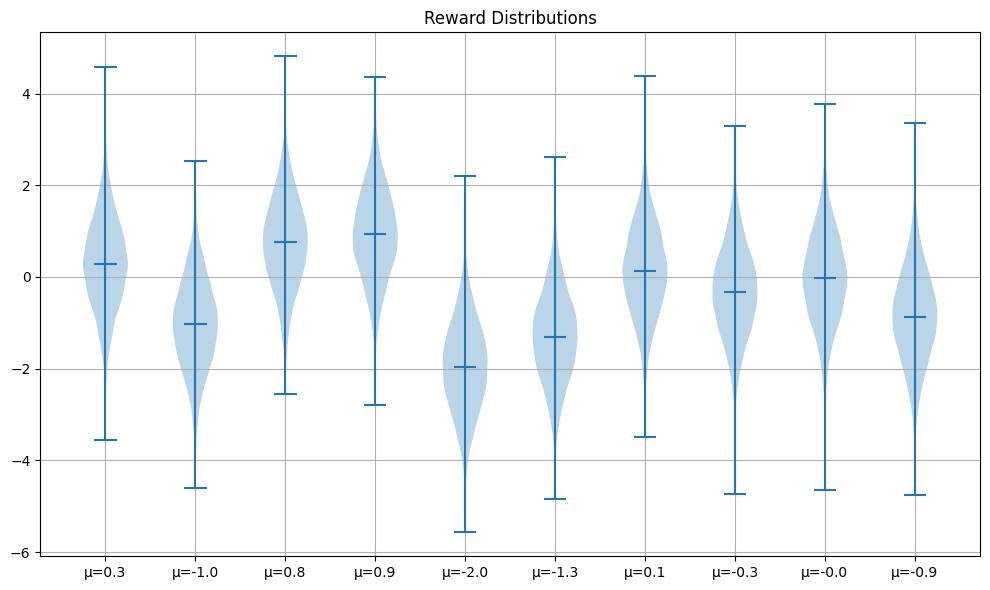

In [13]:
violin_plot_rng: np.random.Generator = np.random.default_rng(196883)

violin_plot_samples: list[npt.NDArray[np.float64]] = [
    violin_plot_rng.normal(loc=mean, scale=ACTION_REWARD_STDEV, size=10_000)
    for mean in ACTION_MEANS
]

plt.figure(figsize=(10, 6))
plt.violinplot(violin_plot_samples, showmeans=True, showmedians=False)
plt.xticks(np.arange(1, NUM_ACTIONS + 1), [f"μ={mu:.1f}" for mu in ACTION_MEANS])
plt.title("Reward Distributions")
plt.grid(True)
plt.tight_layout()
plt.show()


Now we define the non-optimistic (i.e., zero) and optimistic initial values that will be used to initialize the policies. Per the assignment specification, "optimistic" initial values means choosing the initial action-values to be the $99.5^{\text{th}}$ percentile of the normal action reward distribution with the highest mean.


In [14]:
nonoptimistic_initial_values: npt.NDArray[np.float64] = np.zeros(NUM_ACTIONS, dtype=np.float64)

percentile_995: np.float64 = norm.ppf(0.995, loc=MAX_MEAN, scale=ACTION_REWARD_STDEV)
optimistic_initial_values: npt.NDArray[np.float64] = np.full(NUM_ACTIONS, percentile_995, dtype=np.float64)


The following policy factories will be used throughout each of the following experiments, except for the final experiment where a hard reset is used after permuting the action means.

The exploration probability $\varepsilon = 0.1$ for the $\varepsilon$-greedy policy was chosen by conducting small pilot runs of $100$ simulations consisting of $500$ steps each with varying values of $\varepsilon$ ranging from $0.01$ up to $1.0$. While not rigorously optimized, a value of $0.1$ demonstrated near-optimal results in terms of both the average reward per step across the simulations and the proportion of time the optimal action was chosen.

Similarly, the step size $\alpha = 0.1$ for the gradient policy was chosen using the same approach.


In [15]:
nonoptimistic_greedy_policy_factory: PolicyFactory = GreedyPolicyFactory(nonoptimistic_initial_values)

optimistic_greedy_policy_factory: PolicyFactory = GreedyPolicyFactory(optimistic_initial_values)

epsilon: float = 0.1
epsilon_greedy_policy_factory: PolicyFactory = EpsilonGreedyPolicyFactory(epsilon, nonoptimistic_initial_values)

step_size: float = 0.1
gradient_policy_factory: PolicyFactory = GradientPolicyFactory(step_size, nonoptimistic_initial_values)


## Part 1: Stationary Rewards Distributions

As a first experiment, we compare the performance of the non-optimistic greedy, $\varepsilon$-greedy, optimistic greedy, and gradient policies based on the average reward per step and the proportion of optimal action choice across the $1,\,000$ simulation runs.

This first experiment introduces the script that is used throughout the rest of the experiments conducted, where we define the simulation inputs in a `dict` and run simulations from these inputs. The simulation data is analyzed and the average reward and proportion of optimal action curves are visualized. Each plot shows the results for all policies, allowing for at-a-glance performance comparisons.


As a first step in this experiment, we define a stationary actions factory that is used to generate the actions for each simulation run.


In [16]:
stationary_actions_factory: ActionsFactory = StationaryActionsFactory(ACTION_MEANS)


Next, we conduct the experiment following the script described above:

In [ ]:
stationary_simulation_inputs: dict = {
    ("stationary", "greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        stationary_actions_factory,
        nonoptimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("stationary", "greedy", "optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        stationary_actions_factory,
        optimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("stationary", "epsilon-greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        stationary_actions_factory,
        epsilon_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("stationary", "gradient", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        stationary_actions_factory,
        gradient_policy_factory,
        TOP_LEVEL_RNG
    )
}

stationary_simulation_data: dict = {
    key: run_simulations(value) for key, value in stationary_simulation_inputs.items()
}

stationary_average_reward_curves: dict = {
    key: get_average_reward_curve(value) for key, value in stationary_simulation_data.items()
}

stationary_optimal_action_curves: dict = {
    key: get_optimal_action_curve(value) for key, value in stationary_simulation_data.items()
}


Finally, we visualize the results:

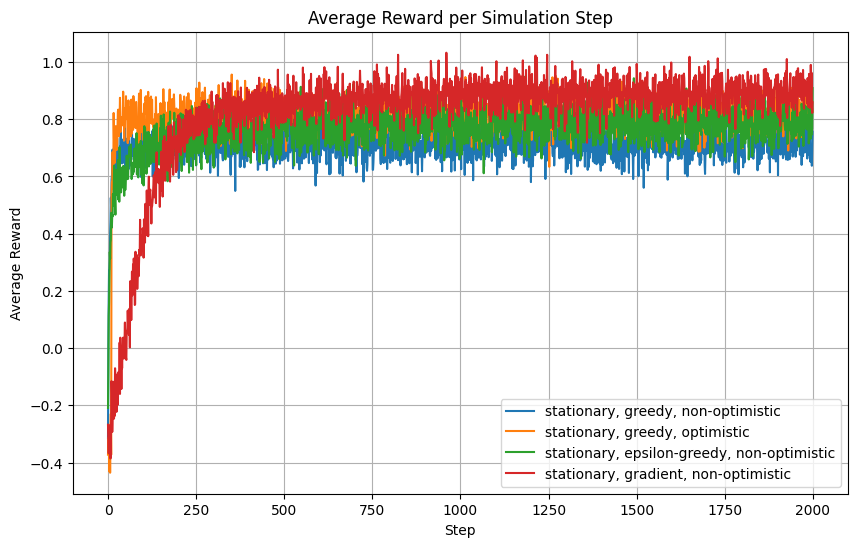

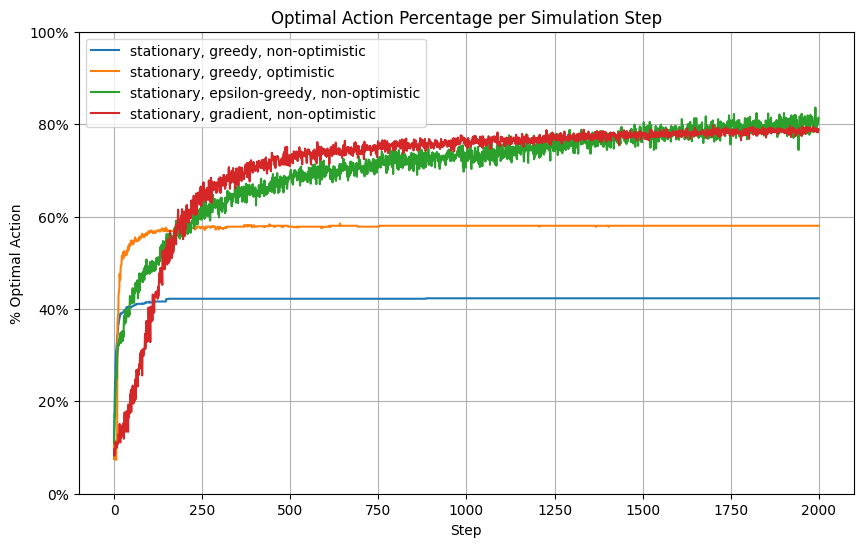

In [42]:
plot_average_reward_curves(stationary_average_reward_curves)
plot_optimal_action_curves(stationary_optimal_action_curves)


As can be seen, in this case the gradient policy outperforms the others in terms of the average reward per step, with the $\varepsilon$-greedy policy following closely behind. The non-optimistic greedy policy performs the worst according to this metric, being outperformed slightly by the optimistic greedy policy.

Looking at the proportion of optimal action, the results follow the same ranking, however, the differences in performance appear much more obvious, at least between the greedy policies and the $\varepsilon$-greedy and the gradient policies.

This ranking is not all that surprising, given the nature of the policies. The greedy policy has the potential to lock in on a suboptimal action and "get stuck" on it (i.e., to lean too far into the exploit end of the explore-exploit trade-off), which appears to manifest in the data. This point stands for both the non-optimistic and optimistic flavours, however, choosing optimistic starting values does produce significantly better results. The $\varepsilon$-greedy policy, by leaning a little toward exploration, leaves room for learning the optimal policy over time---in fact, given infinite time, it is guaranteed to learn the optimal policy. This, too, is seen in the above in that the proportion of optimal action continues to increase over time. Similarly, the gradient policy leaves room for learning in that the action preferences are continually updated over time, which is also observed in the data in the form of a continually increasing proportion of optimal action.

What is somewhat surprising is that the large differences in proportion of optimal actions between the policies corresponds to comparatively smaller differences in average reward per step. Further exploration on this subject could include an investigation into whether this is a consequence of (or, at least, correlate to) the relatively narrow band of reward distributions per the standard deviation of 1. An interesting question, if time allowed, would have been to increase the variance in the action reward distributions and observe the effects.


## Part 2: Nonstationary Reward Distributions

### 2.1: Gradual Changes

#### 2.1.1: Gradual Drift

As a first step in this experiment, we create a drifting actions factory with $\kappa = 1$, as captured in the `drifting_drift_mean_persistence` variable. Per the assignment specification, the drift perturbations $\varepsilon_{i, t}$ are sampled from $N(0, 1)$. As discussed above, a "drift seed" is passed in to ensure that each of the `DriftingActions` objects produced by the factor follows the same sequence of $\varepsilon_{i, t}$, ensuring that subsequent simulation runs are comparable.

Though "environment" is not a concept that was introduced with the $k$-armed bandit framework, ensuring a consistent sequence of action reward distribution means seems roughly like ensuring a consistent environment for each simulation, if we consider the reward distributions themselves to be aspects of the environment. In this light, it makes sense why we would require a consistent sequence of drift permutations in order to be able to compare the results of each simulation: if the environment were different with each simulation run, the simulations would not be comparing the performance of the algorithms in the same "world", as it were.


In [21]:
drifting_drift_mean_persistence: float = 1.0
drifting_drift_mean: float = 0.0
drifting_drift_stdev: float = 0.01
drifting_drift_seed: int = 1337
drifting_actions_factory: ActionsFactory = DriftingActionsFactory(
    ACTION_MEANS,
    drifting_drift_mean_persistence,
    drifting_drift_mean,
    drifting_drift_stdev,
    drifting_drift_seed
)


Following the same script as used in Part 1, we define the simulation inputs, run the simulations, and extract the data to produce our metrics.


In [ ]:
drifting_simulation_inputs: dict = {
    ("drifting", "greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        drifting_actions_factory,
        nonoptimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("drifting", "greedy", "optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        drifting_actions_factory,
        optimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("drifting", "epsilon-greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        drifting_actions_factory,
        epsilon_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("drifting", "gradient", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        drifting_actions_factory,
        gradient_policy_factory,
        TOP_LEVEL_RNG
    )
}

drifting_simulation_data: dict = {
    key: run_simulations(value) for key, value in drifting_simulation_inputs.items()
}

drifting_average_reward_curves: dict = {
    key: get_average_reward_curve(value) for key, value in drifting_simulation_data.items()
}

drifting_optimal_action_curves: dict = {
    key: get_optimal_action_curve(value) for key, value in drifting_simulation_data.items()
}


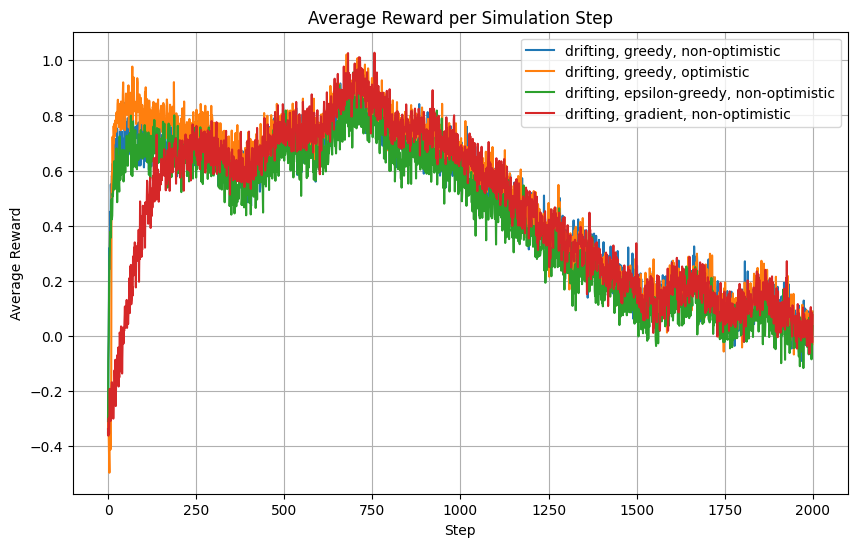

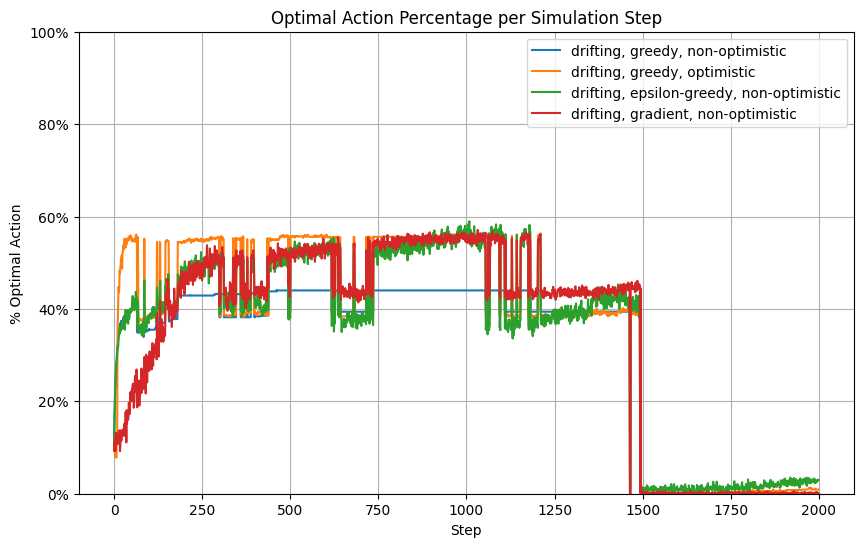

In [43]:
plot_average_reward_curves(drifting_average_reward_curves)
plot_optimal_action_curves(drifting_optimal_action_curves)


In this case, the data, while messy, tells the story that, as the actions' reward distribution means drift, the optimal and next-to-optimal actions swap supremacy intermittently until around time step $t = 1,\,500$, where something dramatic happens. The following plot shows this more explicitly:

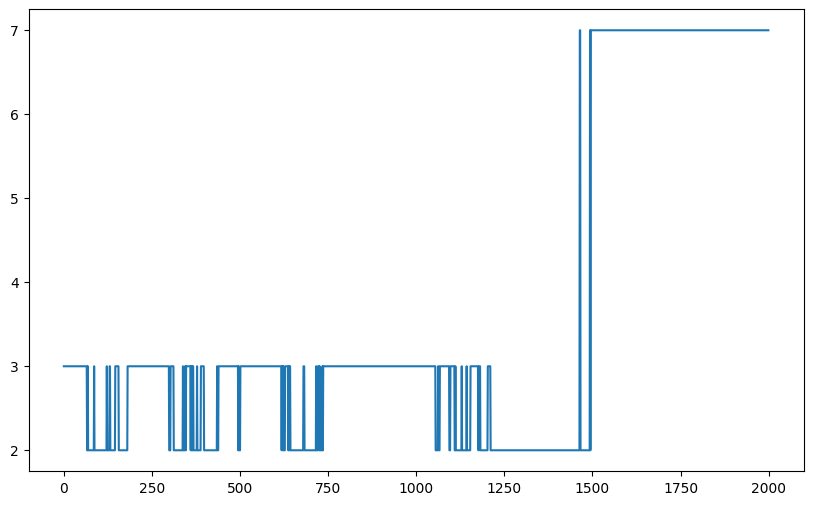

In [45]:
drifting_optimal_actions = [
    d.optimal_actions for d in drifting_simulation_data[("drifting", "greedy", "non-optimistic")]
]

plt.figure(figsize=(10, 6))
plt.plot(drifting_optimal_actions[1])
plt.show()


As can be seen, action 3 starts as the optimal action (as expected, given the violin plot above) and intermittently swaps places with action 2 until around time step $t = 1,\,500$, where action 7 becomes the optimal action. None of the policies do a particularly good job of adapting to this scenario, as can be seen with in the declining average reward per time step curve and the erratic proportion of optimal action curve.

The $\varepsilon$-greedy policy appears to recover more rapidly than the others, as indicated by the fact that the proportion of optimal action curve visibly increases whenever there is an extended period of consistent optimal action. However, the recovery is slow compared to the pace of the non-stationarity.


#### 2.1.2: Mean-Reverting Change

Next, we create a mean-reverting change process with $\kappa = 0.5$. In this case, we expect all actions' reward distribution means to decay toward and randomly walk around zero.

In [26]:
mean_reverting_drift_mean_persistence: float = 0.5
mean_reverting_drift_mean: float = 0.0
mean_reverting_drift_stdev: float = 0.01
mean_reverting_drift_seed: int = 271828
mean_reverting_actions_factory: ActionsFactory = DriftingActionsFactory(
    ACTION_MEANS,
    mean_reverting_drift_mean_persistence,
    mean_reverting_drift_mean,
    mean_reverting_drift_stdev,
    mean_reverting_drift_seed
)


Following the same script as above:

In [ ]:
mean_reverting_simulation_inputs: dict = {
    ("mean-reverting", "greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        mean_reverting_actions_factory,
        nonoptimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-reverting", "greedy", "optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        mean_reverting_actions_factory,
        optimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-reverting", "epsilon-greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        mean_reverting_actions_factory,
        epsilon_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-reverting", "gradient", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        mean_reverting_actions_factory,
        gradient_policy_factory,
        TOP_LEVEL_RNG
    )
}

mean_reverting_simulation_data: dict = {
    key: run_simulations(value) for key, value in mean_reverting_simulation_inputs.items()
}

mean_reverting_average_reward_curves: dict = {
    key: get_average_reward_curve(value) for key, value in mean_reverting_simulation_data.items()
}

mean_reverting_optimal_action_curves: dict = {
    key: get_optimal_action_curve(value) for key, value in mean_reverting_simulation_data.items()
}


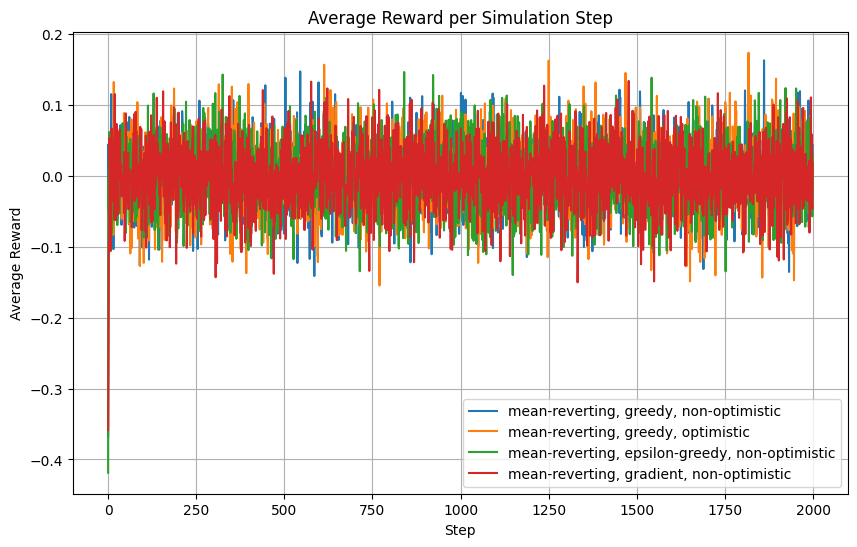

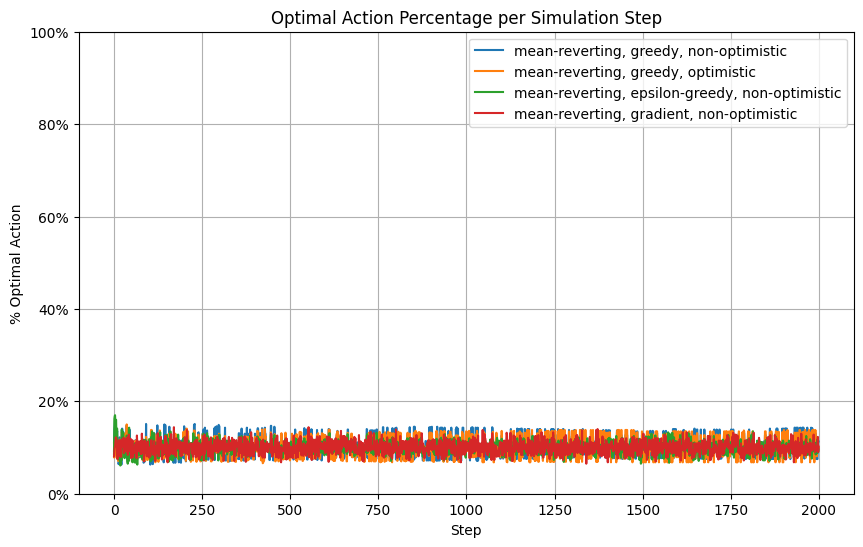

In [46]:
plot_average_reward_curves(mean_reverting_average_reward_curves)
plot_optimal_action_curves(mean_reverting_optimal_action_curves)


In this case, both the average reward per step and the proportion of optimal action curves just appear to be random noise. The proportion of optimal action looks as though actions are being chosen at random, with a $10\%$ chance of hitting on the optimal action. This makes sense given the dynamics of the actions' reward distributions, which all revert to normal distributions with means dancing around zero. In such a scenario, it seems reasonable that none of the policies would perform well, given that finding the optimal action under these conditions is an extremely difficult task, and that the optimality of any given action is likely to be short-lived.

### 2.2: Abrupt Changes

We now examine the case where the actions' reward distribution means undergo a random permutation at time step $t = 501$. As a first step, we define a permuting actions factory that will be used to generate the same permutation in each simulation run.

In [31]:
permutation_time_step: int = 501
permutation_seed: int = 3141593
permuting_mean_actions_factory: ActionsFactory = PermutingMeanActionsFactory(
    ACTION_MEANS,
    permutation_time_step,
    permutation_seed
)


#### 2.2.1: Mean Permutation without Reset

In the first case, we assume we have no knowledge of when the permutation will take place. The policies are expected to pick up from where they left off prior to the shuffling and relearn the optimal action.

In [ ]:
permuting_mean_simulation_inputs: dict = {
    ("mean-permuting", "greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        nonoptimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-permuting", "greedy", "optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        optimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-permuting", "epsilon-greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        epsilon_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-permuting", "gradient", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        gradient_policy_factory,
        TOP_LEVEL_RNG
    )
}

permuting_mean_simulation_data: dict = {
    key: run_simulations(value) for key, value in permuting_mean_simulation_inputs.items()
}

permuting_mean_average_reward_curves: dict = {
    key: get_average_reward_curve(value) for key, value in permuting_mean_simulation_data.items()
}

permuting_mean_optimal_action_curves: dict = {
    key: get_optimal_action_curve(value) for key, value in permuting_mean_simulation_data.items()
}


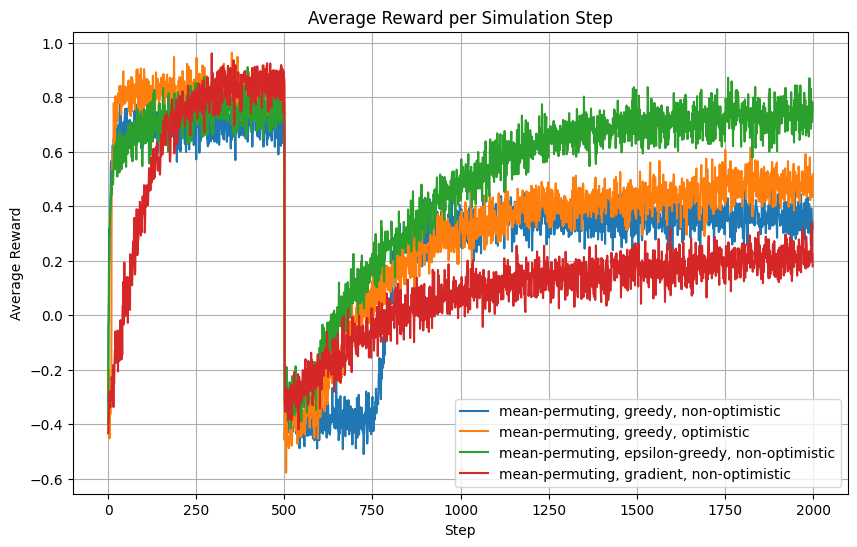

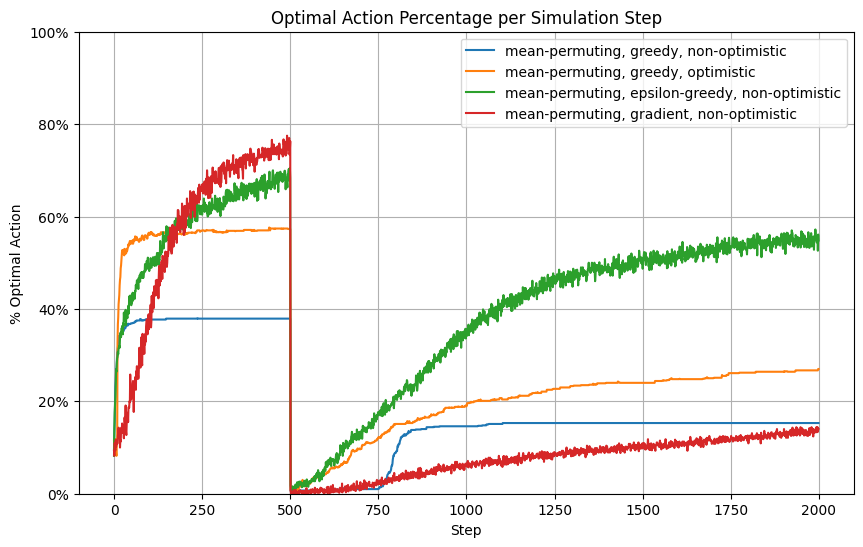

In [47]:
plot_average_reward_curves(permuting_mean_average_reward_curves)
plot_optimal_action_curves(permuting_mean_optimal_action_curves)


Under these conditions, each of the policies' performance clearly, and expectedly, drops dramatically when the permutation occurs. Each of them eventually recovers to a degree, but never regains the same performance enjoyed prior to the shuffling. The best-performing policy is the $\varepsilon$-greedy policy, which not only recovers more quickly than the other policies, but recovers its average reward per time step and proportion of optimal action significantly better than the others.

#### 2.2.2: Mean-Reverting with Reset

In this case, we assume that we do have prior knowledge of when the shuffle will occur, and we essentially erase what each of the policies had learned before the shuffle.

As a first step, we define new policy factories with the reset time step specified.

In [48]:
resetting_nonoptimistic_greedy_policy_factory: PolicyFactory = GreedyPolicyFactory(
    nonoptimistic_initial_values,
    permutation_time_step
)

resetting_optimistic_greedy_policy_factory: PolicyFactory = GreedyPolicyFactory(
    optimistic_initial_values,
    permutation_time_step
)

epsilon: float = 0.1
resetting_epsilon_greedy_policy_factory: PolicyFactory = EpsilonGreedyPolicyFactory(
    epsilon,
    nonoptimistic_initial_values,
    permutation_time_step
)

step_size: float = 0.1
resetting_gradient_policy_factory: PolicyFactory = GradientPolicyFactory(
    step_size,
    nonoptimistic_initial_values,
    permutation_time_step
)


Then, we just follow the usual script to generate the simulation inputs, simulation data, and visualizations of the performance metrics.

In [ ]:
permuting_mean_with_reset_simulation_inputs: dict = {
    ("mean-permuting-with-reset", "greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        resetting_nonoptimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-permuting-with-reset", "greedy", "optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        resetting_optimistic_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-permuting-with-reset", "epsilon-greedy", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        resetting_epsilon_greedy_policy_factory,
        TOP_LEVEL_RNG
    ),
    ("mean-permuting-with-reset", "gradient", "non-optimistic"): get_simulation_inputs(
        NUM_SIMULATIONS,
        NUM_STEPS_PER_SIM,
        permuting_mean_actions_factory,
        resetting_gradient_policy_factory,
        TOP_LEVEL_RNG
    )
}

permuting_mean_with_reset_simulation_data: dict = {
    key: run_simulations(value) for key, value in permuting_mean_with_reset_simulation_inputs.items()
}

permuting_mean_with_reset_average_reward_curves: dict = {
    key: get_average_reward_curve(value) for key, value in permuting_mean_with_reset_simulation_data.items()
}

permuting_mean_with_reset_optimal_action_curves: dict = {
    key: get_optimal_action_curve(value) for key, value in permuting_mean_with_reset_simulation_data.items()
}


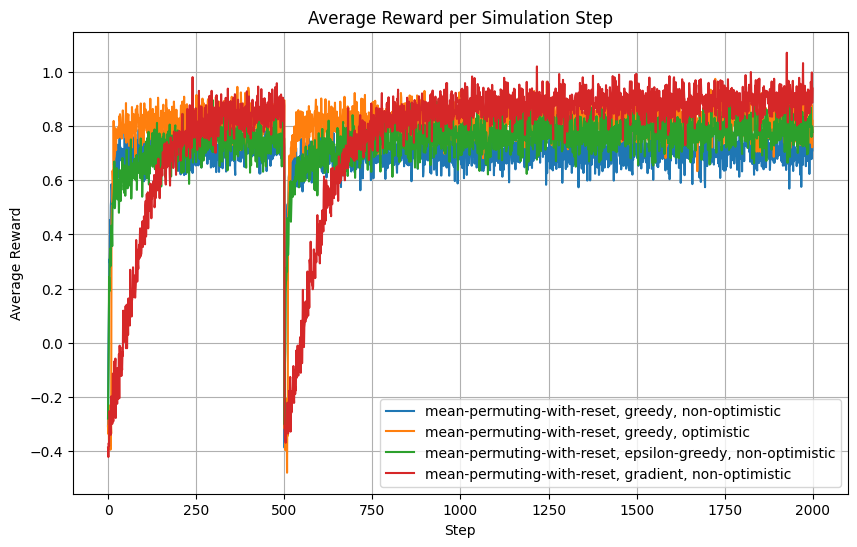

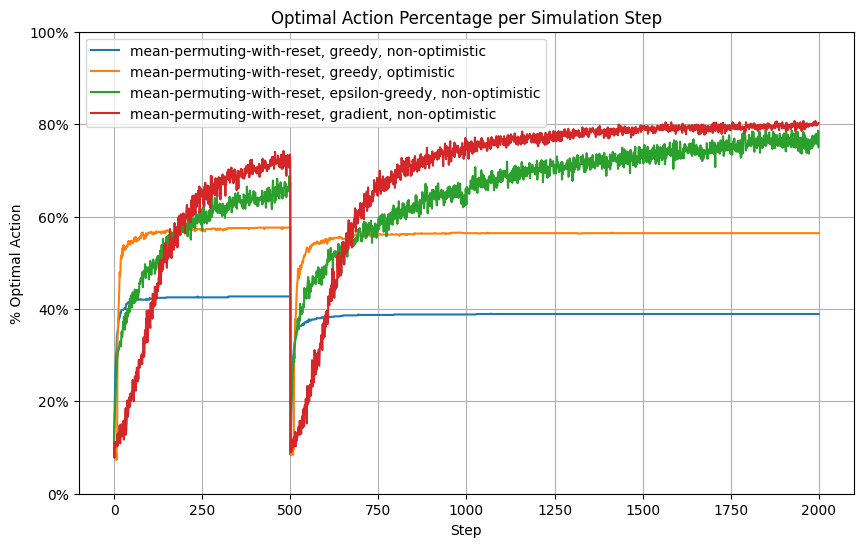

In [49]:
plot_average_reward_curves(permuting_mean_with_reset_average_reward_curves)
plot_optimal_action_curves(permuting_mean_with_reset_optimal_action_curves)


In this case, perhaps expectedly, the policies adapt quickly and recover to their pre-shuffle performance as though it never happened. This suggests that, in a non-stationary world, a good strategy might be to detect when performance has degraded significantly and to do a similar hard reset in order to relearn from scratch.